There is a lot of information on [runners and their performance for the Boston Marathon.](https://github.com/llimllib/bostonmarathon) Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

# Load/Inspect Data

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# load data for 2013
url='https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv'
df=pd.read_csv(url, header=0, encoding='utf8', sep=',')
# show format
df.describe()

,age,division,official,overall,pace,genderdiv
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000
mean,41.638332,1100.967025,208.159470,8429.373422,7.947398,4351.684732
std,10.351311,942.114816,23.743608,5052.024116,0.905739,2772.398239
min,18.000000,1.000000,85.530000,1.000000,3.270000,1.000000
25%,34.000000,363.000000,191.727500,4061.750000,7.320000,2032.750000
50%,42.000000,842.000000,209.225000,8247.500000,7.980000,4113.500000
75%,49.000000,1560.000000,225.230000,12662.250000,8.600000,6316.000000
max,80.000000,3834.000000,284.230000,17598.000000,10.850000,10648.000000


This report will focus on exploring overall rank, and seeing if anyting can be found from clusters that shows what gives a person a better chance of finishing the race faster. 

The ctz and state columns did not import correctly, so they wil be dropped. Also, bib number is a unique identifier for each racer and will not inform about the data, so it will be dropped. Gender will be converted to dummy categories for modelling. In addition, we will be first inspecting with means-shift so will remove all columns with string data. 

In [2]:
# create means-shift dataframe
df_ms=df.copy()
# add dummy columns for gender and concatenate wit df_ms
gender=pd.get_dummies(df_ms['gender'])
df_ms=pd.concat([df_ms, gender], 1)

In [3]:
# see what countries have the most racers
df_ms['country'].value_counts()

USA    13167
CAN     1533
GBR      179
JPN      109
MEX      108
GER       86
BRA       81
AUS       78
ITA       76
FRA       66
ESP       51
SWE       48
DEN       45
NED       42
SUI       37
HKG       32
COL       29
IRL       28
SIN       23
AUT       22
NOR       21
VEN       21
CRC       20
KOR       19
CHI       16
ISL       15
RUS       14
POL       14
ARG       13
GUA       12
       ...  
CZE        7
BER        5
TWN        5
ECU        5
MAS        4
SLO        4
ETH        4
LTU        4
ISR        4
IND        3
CAY        3
PER        3
URU        3
ESA        2
BAH        2
HUN        2
UKR        2
ARU        2
EST        2
UAE        2
PAN        2
DOM        2
TUR        1
POR        1
BOL        1
TCA        1
VGB        1
PHI        1
QAT        1
TRI        1
Name: country, Length: 68, dtype: int64

There are too many countries in teh dataset to create cateogrical variables, and creating them would skew the logic in the data. 

In [4]:
# drop ctz and state columns
df_ms=df_ms.drop(['ctz', 'bib', 'state', 'name', 'city', 'country'], 1)
df_ms.head()

,25k,age,division,10k,gender,half,official,overall,pace,30k,5k,genderdiv,20k,35k,40k,F,M
0,49.87,28,9,18.18,M,40.93,90.90,9,3.47,62.07,8.90,9,38.80,74.73,85.55,0,1
1,77.27,30,5,30.90,M,64.90,132.50,5,5.07,92.97,15.90,5,61.52,108.78,124.77,0,1
2,77.23,23,1,30.90,M,64.92,130.37,1,4.98,92.72,15.93,1,61.53,108.68,123.78,0,1
3,50.50,32,5,18.73,M,42.00,88.43,5,3.38,61.35,8.98,5,39.88,73.00,83.43,0,1
4,48.75,39,3,18.18,M,40.57,87.22,3,3.33,59.92,8.92,3,38.55,71.68,81.88,0,1


There are some '-' characters in the data that are preventing the model from running. Where are these characters?

In [5]:
df_ms.select_dtypes([np.object]).apply(lambda x: x.str.contains('-').any())

25k        True
10k        True
gender    False
half       True
30k        True
5k         True
20k        True
35k        True
40k        True
dtype: bool

It looks like the '-' characters relate to when a runner did not pass a certain checkpoint, so these rows will be dropped.

In [6]:
# replace - with null 
df_ms['25k']=df_ms['25k'].replace('-', np.nan)
df_ms['10k']=df_ms['10k'].replace('-', np.nan)
df_ms['half']=df_ms['half'].replace('-', np.nan)
df_ms['half']=df_ms['half'].replace('-', np.nan)
df_ms['30k']=df_ms['30k'].replace('-', np.nan)
df_ms['5k']=df_ms['5k'].replace('-', np.nan)
df_ms['20k']=df_ms['20k'].replace('-', np.nan)
df_ms['35k']=df_ms['35k'].replace('-', np.nan)
df_ms['40k']=df_ms['40k'].replace('-', np.nan)

# drop all rows with null values
df_ms=df_ms.dropna(axis=0)

The columns with object dtype will need to be converted to float.

In [7]:
# convert all object columns to float
df_ms['25k']=df_ms['25k'].astype(float)
df_ms['10k']=df_ms['10k'].astype(float)
df_ms['half']=df_ms['half'].astype(float)
df_ms['half']=df_ms['half'].astype(float)
df_ms['30k']=df_ms['30k'].astype(float)
df_ms['5k']=df_ms['5k'].astype(float)
df_ms['20k']=df_ms['20k'].astype(float)
df_ms['35k']=df_ms['35k'].astype(float)
df_ms['40k']=df_ms['40k'].astype(float)

In [9]:
# k-means
from sklearn.cluster import MeanShift, estimate_bandwidth
#Divide into training and test sets.
A=df_ms.drop(['gender'], 1)
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(A, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(A)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

labels_unique = np.unique(labels)

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 3


Means-shift returns three clusters from the data. What can we find from the clusters? 

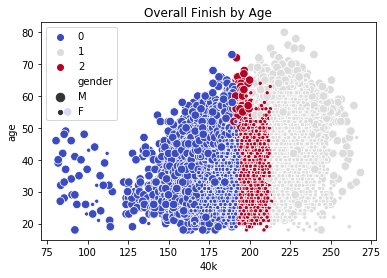

In [10]:
# see how the clusters group by age and overall finish 
plt.title('Overall Finish by Age')
sns.scatterplot('40k', 'age', size='gender', data=df_ms, hue=labels, palette='coolwarm')

The clusters are not dependent on age. How does pace relate to official time?

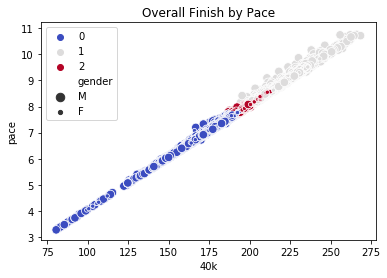

In [11]:
# see how the clusters group by pace and overall finish 
plt.title('Overall Finish by Pace')
sns.scatterplot('40k', 'pace', size='gender', data=df_ms, hue=labels, palette='coolwarm')

This plot shows that overall rank is dependent on pace. Also, it seems that pace has a logarithmic relationship to overall rank. 

One pattern emerging from these two plots is the clusters seem to relate to a first, second, and third grouping in terms of overall finish. However, while difficult to spot on the plot above, gender may also be a clustering border. In order to test whether the clusters depend on gender or time, a KNN classifier will be created and tested on the cluster.  

In [44]:
X = df_ms.drop(['gender'], 1)
y = labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)
cv_results = cross_validate(neigh, X, y, cv=5, return_train_score=False)
print(neigh.score(X_test, y_test))
print(cv_results)

0.9984428526938648
{'fit_time': array([0.01982379, 0.013134  , 0.01062393, 0.0098629 , 0.00993395]), 'score_time': array([0.0270772 , 0.01478195, 0.01445985, 0.01476407, 0.01414204]), 'test_score': array([0.9367995 , 0.99750934, 0.99906542, 0.99844237, 0.98566978])}


The KNN model looks accurate and balanced. How does the model classify the data?

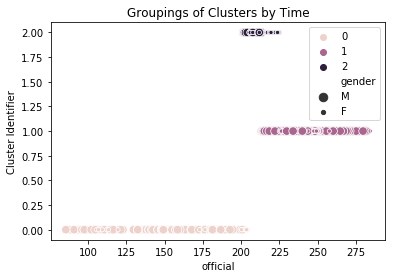

In [58]:
# create groupings of predictions
predictions=neigh.predict(X)

# plot the official times by the predictors from the KNN model, along with the gender from the data 
plt.title('Groupings of Clusters by Time')
plt.ylabel('Cluster Identifier')
sns.scatterplot('official', predictions, data=df_ms, hue=labels, size='gender')

# Summary
The clusters from the means-shift match the clusters from the KNN model. In addition, all 3 populations have male and female competitors, showing the clusters are dependent on time and not gender. 